<h3>Sentiment Analysis (Evaluations)</h3>

1. DATA EXPLORATION

2. PRE-TRAINED MODELS: COMPARING PERFORMANCE

In [8]:
import pandas as pd

In [9]:
comments=pd.read_excel('comments.xlsx')
comments

,Comments
0,This medical student demonstrated excellent pr...
1,They remained calm and composed under pressure...
2,This medical student showed excellent critical...
3,They were able to prioritize tasks effectively...
4,This medical student showed excellent communic...
5,They were able to adapt to unexpected challeng...
6,This medical student showed excellent attentio...
7,"They were able to work independently, demonstr..."
8,This medical student showed excellent clinical...
9,They were able to manage complex patient cases...


In [8]:
#install vaderSentimentlibrary
!pip install vaderSentiment

#import the library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return negative, neutral, positive, compound, overall_sentiment

  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
     ---------------------------------------- 0.0/97.1 kB ? eta -:--:--
     ---------------------------------------- 97.1/97.1 kB 5.8 MB/s eta 0:00:00
  Using cached idna-3.4-py3-none-any.whl (61 kB)
  Using cached urllib3-1.26.15-py2.py3-none-any.whl (140 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)


In [24]:
a=comments.apply(lambda x: sentiment_vader(x['Comments']),axis=1)
a.iloc[46]

(0.181, 0.819, 0.0, -0.4767, 'Negative')

In [20]:

# install textblob
!pip install textblob

# import it
from textblob import TextBlob

#call the classifier
def sentiment_texblob(row):
  
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    subjectivity = classifier.sentiment.subjectivity
    
    return polarity,subjectivity

     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
     -------------------------------- ---- 563.2/636.8 kB 12.0 MB/s eta 0:00:01
     ------------------------------------- 636.8/636.8 kB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     --------------------- ------------------ 0.8/1.5 MB 26.4 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 24.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/77.1 kB ? eta -:--:--
     ---------------------------------------- 77.1/77.1 kB ? eta 0:00:00
     ---------------------------------------- 0.0/267.7 kB ? eta -:--:--
     -------------------------- ---------- 194.6/267.7 kB 12.3 MB/s eta 0:00:01
     -------------------------- ---------- 194.6/267.7 kB 12.3 MB/s eta 0:00:01
     -------------------------- ---------- 194.6/267.7 kB 12.3 MB/s eta 0:00:01
     -------------------------- ---------- 194.6/267.7 kB 12.3 MB/s eta 0:00:01


In [26]:
b=comments.apply(lambda x: sentiment_texblob(x['Comments']),axis=1)
b

0                     (0.4833333333333333, 0.575)
1                   (-0.09999999999999998, 0.875)
2                                    (0.225, 0.7)
3        (0.3666666666666667, 0.8083333333333332)
4      (0.29500000000000004, 0.43499999999999994)
                          ...                    
204     (0.06727272727272726, 0.5909090909090909)
205     (0.37878787878787873, 0.6515151515151515)
206                                   (0.1, 0.45)
207      (0.4454545454545455, 0.5181818181818182)
208                   (-0.07500000000000001, 0.6)
Length: 209, dtype: object

In [ ]:
!pip install happytransformer
from happytransformer import HappyTextClassification
happy_tc=HappyTextClassification(model_type='DISTILBERT',model_name='distilbert-base-uncased-finetuned-sst-2-english',num_labels=2)


In [28]:
c=comments.apply(lambda x: happy_tc.classify_text(x['Comments']),axis=1)

In [29]:
c

0      TextClassificationResult(label='POSITIVE', sco...
1      TextClassificationResult(label='POSITIVE', sco...
2      TextClassificationResult(label='POSITIVE', sco...
3      TextClassificationResult(label='POSITIVE', sco...
4      TextClassificationResult(label='POSITIVE', sco...
                             ...                        
204    TextClassificationResult(label='POSITIVE', sco...
205    TextClassificationResult(label='NEGATIVE', sco...
206    TextClassificationResult(label='POSITIVE', sco...
207    TextClassificationResult(label='NEGATIVE', sco...
208    TextClassificationResult(label='POSITIVE', sco...
Length: 209, dtype: object

In [2]:
!pip install sklearn
!pip install sentence-transformers

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2936 sha256=10dffa1c852006c2ffa3d9224d9e07db48a869709fdea472b956024280987bc5
  Stored in directory: c:\users\wongqihuiyve\appdata\local\pip\cache\wheels\f8\e0\3d\9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
     ---------------------------------------- 86.0/86.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 6.3/6.3 MB 12.6 MB/s eta 0:00:00
     -------------------------------------- 162.5/162.5 MB 6.5 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 17.5 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 17.8 MB/s eta 0:00:00
     ------------------------------------- 199.2/199.2 kB 11.8 MB/s eta 0:00:00
 

In [78]:
import pandas as pd
comments=pd.read_excel('comments.xlsx')

from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

n_gram_range = (1, 1)
stop_words = "english"

sentences=comments['Comments'].values.tolist()
# Extract candidate words/phrases
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(sentences)
candidates = count.get_feature_names()

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)
doc_embedding
comments['Doc_Embed']=comments.apply(lambda x: model.encode([x['Comments']]),axis=1)
comments['Distance']=comments.apply(lambda x:cosine_similarity(x['Doc_Embed'],candidate_embeddings),axis=1)
top_n = 5

comments['Keywords']=comments['Distance'].apply(lambda x: [candidates[index] for index in x.argsort()[0][-top_n:]])

c:\Users\WongQiHuiYve\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [79]:
comments['Keywords']

0        [learning, patient, medical, healthcare, exam]
1           [working, practical, ease, carefully, calm]
2        [clinical, exam, patient, healthcare, medical]
3     [working, understanding, effective, practical,...
4        [patients, exam, patient, medical, healthcare]
5     [adapt, skills, demonstrating, learning, adjus...
6        [clinical, patient, exam, medical, healthcare]
7     [manage, prioritize, independently, practical,...
8        [exam, clinical, patient, medical, healthcare]
9     [clinical, understanding, diagnose, healthcare...
10         [exam, skills, patient, healthcare, medical]
11    [rude, flustered, unprepared, unprofessional, ...
12    [delays, difficult, rude, overwhelmed, flustered]
13    [patients, unprofessional, patient, healthcare...
14        [tension, delays, rude, difficult, flustered]
15    [absent, lack, unprepared, unprofessional, unc...
16    [difficult, rude, uncooperative, delays, flust...
17    [student, dismissive, unprofessional, flus

In [87]:

# QUESTION ANSWERING: Very very bad
from transformers import pipeline

# Load sentiment analysis and question answering models
sa_model = pipeline("sentiment-analysis")
qa_model = pipeline("question-answering")

# Review to analyze

comments['Sentiment']=comments['Comments'].apply(lambda x: sa_model(x)[0]['label'])


def get_q_list(row):
    q_list=[]
    for i in row['Keywords']:
        q_list.append(f'Why was it {i}?')
    return q_list
comments['Questions']=comments.apply(get_q_list,axis=1)

def get_a_list(row):
    a_list=[]
    for i in row['Questions']:
        a_list.append(qa_model(question=i, context=row['Comments'])['answer'])
    return a_list
comments['Answers']=comments.apply(get_a_list,axis=1)
print(comments[['Answers','Questions']])


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


                                              Answers  \
0   [quickly identifying issues and developing eff...   
1   [pressure, working through difficult scenarios...   
2   [excellent critical thinking skills, excellent...   
3   [managing their time well, They were able to p...   
4   [excellent communication skills, excellent com...   
5   [to overcome obstacles, adjusting their approa...   
6   [ensuring that all necessary information was r...   
7   [demonstrating initiative, They were able to w...   
8   [clinical judgement, making sound decisions ba...   
9   [problem-solving skills, to provide appropriat...   
10  [excellent communication skills, communication...   
11  [lack of commitment to their work, lack of com...   
12  [They were unable to work effectively under pr...   
13  [lack of understanding of the ethical consider...   
14  [They were frequently uncooperative and diffic...   
15  [failing to seek out opportunities to expand t...   
16  [They were unable to effect

In [ ]:
from transformers import pipeline

# Load sentiment analysis and question answering models
sa_model = pipeline("sentiment-analysis")
qa_model = pipeline("question-answering")



In [31]:
# Review to analyze
review = "This medical student has excellent communication skills, effectively conveying complex medical concepts"

# Perform sentiment analysis on the review
sentiment = sa_model(review)[0]['label']

# Extract key phrases from the review
key_phrases = ['communication','concepts']

# Generate questions based on the sentiment and key phrases
if sentiment == 'POSITIVE':
    questions = ['What made it good?']
elif sentiment == 'NEGATIVE':
    questions = ['Why was it bad?']
else:
    questions = ['What can you say about it?']

# Use QA to answer the questions
answers = []
for question in questions:
    answer = qa_model(question=question, context=review)
    answers.append(answer['answer'])

# Print the sentiment and answers
print('Sentiment:', sentiment)
print('Answers:', answers)


Sentiment: POSITIVE
Answers: ['communication skills']


In [67]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

# Define a list of documents to use for topic modeling
documents = comments['Comments'].values.tolist()

# Preprocess the documents by tokenizing and removing stop words
stopwords = set(gensim.parsing.preprocessing.STOPWORDS)
texts = [[word for word in document.lower().split() if word not in stopwords]
         for document in documents]

# Create a dictionary and bag-of-words representation of the documents
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train an LDA model on the corpus
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=10)

# Print the top words for each topic
for topic in lda_model.print_topics():
    print(topic)

(0, '0.041*"able" + 0.031*"difficult" + 0.022*"work" + 0.022*"ensuring" + 0.022*"necessary" + 0.013*"effectively," + 0.013*"frequently" + 0.013*"completed." + 0.013*"time" + 0.013*"managing"')
(1, '0.033*"patient" + 0.032*"effectively" + 0.032*"unable" + 0.020*"care." + 0.019*"healthcare" + 0.018*"work" + 0.018*"causing" + 0.018*"lack" + 0.018*"pressure," + 0.018*"collaborate"')
(2, '0.079*"medical" + 0.062*"student" + 0.037*"excellent" + 0.037*"showed" + 0.026*"skills," + 0.020*"demonstrated" + 0.020*"communication" + 0.020*"effectively" + 0.018*"patient" + 0.014*"conveying"')


In [69]:
!pip install wordcloud

     -------------------------------------- 153.1/153.1 kB 4.6 MB/s eta 0:00:00


In [71]:
!pip install matplotlib

In [74]:
from matplotlib import pyplot as plt

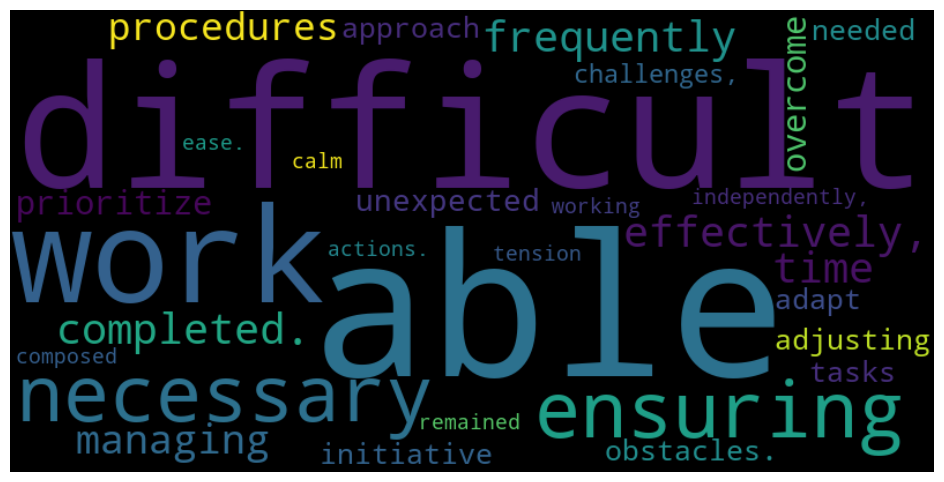

In [75]:
# TOPIC MODELLING: does not look very insightful

from wordcloud import WordCloud

# Generate a word cloud for the first topic
topic_words = lda_model.show_topic(0, 30)
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(dict(topic_words))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# sentiment analysis, topic modelling, QA, keyword extraction/ner

# self trained model, online dataset
# fine tuning an existing model, self labelled dataset
# self trained model, self labelled dataset

# possible insights: if a certain programme has more negative comments, can reconsider the curriculum of the programe
# other options for future consideration: amazon comprehend, google natural language api
# limitation: word cannot be too long